In [2]:
# Étape 1 : Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Étape 2 : Chargement des données

# Charger ton fichier de features
features_df = pd.read_csv("../features/features_transactions.csv") 
print("features charge")

features charge


In [3]:
#-------------------- algorithme Isolation Forest---------

# Etape 3 : pretraitement des donnees 

#selection des colonnes numeriques
numeric_cols = features_df.select_dtypes(include=['float64', 'int64']).columns 

# Remplacement des valeurs manquantes par 0
features_df[numeric_cols] = features_df[numeric_cols].fillna(0) 

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df[numeric_cols])

print("normalisation reussi")

normalisation reussi


In [4]:
# Etape 4 : Application de l'Isolation Forest

# Initialisation du modèle (paramètres ajustables)
model = IsolationForest(
    contamination=0.03,      # % estimé d'anomalies
    n_estimators=100,        # nombre d’arbres dans la forêt
    random_state=42          # pour reproductibilité
)

# Entraînement du modèle
model.fit(X_scaled)

# Prédiction : 1 = normal, -1 = anomalie
features_df['anomalie'] = model.predict(X_scaled)



# Étape 5 : Réduction de dimension (PCA)

# On réduit les données à 2 dimensions pour pouvoir les afficher en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


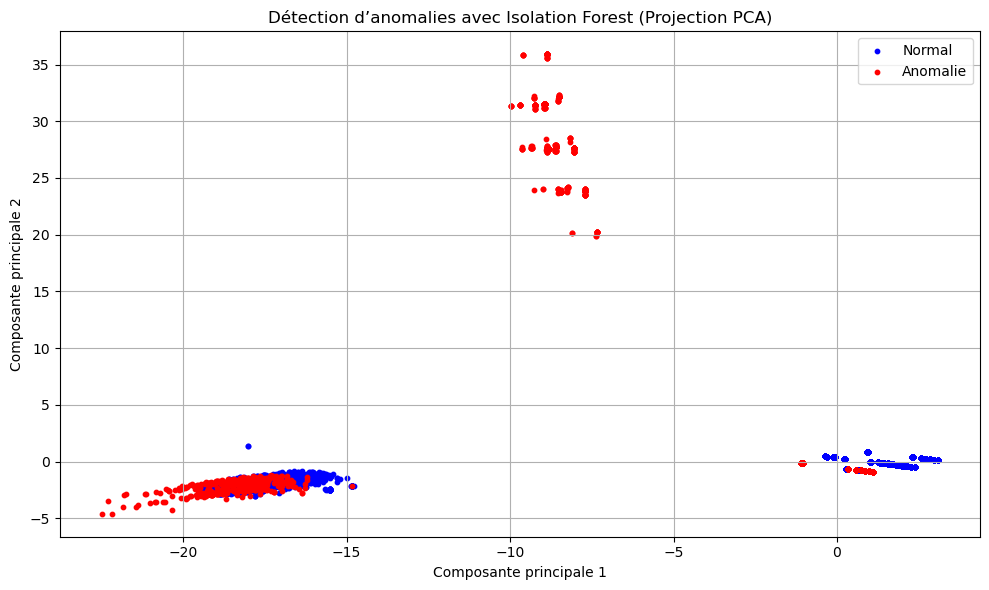

In [5]:
# Étape 6 : Visualisation avec matplotlib

# Création du graphe
plt.figure(figsize=(10, 6))

# Points normaux
plt.scatter(
    X_pca[features_df['anomalie'] == 1, 0], 
    X_pca[features_df['anomalie'] == 1, 1], 
    c='blue', label='Normal', s=10
)

# Points anormaux
plt.scatter(
    X_pca[features_df['anomalie'] == -1, 0], 
    X_pca[features_df['anomalie'] == -1, 1], 
    c='red', label='Anomalie', s=10
)

# Habillage du graphe
plt.title("Détection d’anomalies avec Isolation Forest (Projection PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Affichage du graphe
plt.show()

In [6]:
# Etape 7 : Ajouter les prédictions au DataFrame original

# Ajout d'une colonne is_fraud : 1 pour fraude, 0 pour normal
features_df['is_fraud'] = [1 if x == -1 else 0 for x in model.predict(X_scaled)]

#. Afficher le nombre total de fraudes détectées
nombre_fraudes = features_df['is_fraud'].sum()
print(f"Nombre de fraudes détectées : {nombre_fraudes}")

# 3. Extraire les transactions suspectes
features_df_fraudes = features_df[features_df['is_fraud'] == 1]

# Sauvegarde (ajout de is_fraud au dataset)
features_df.to_csv("../features/features_transactions_isolation_forest_avec_fraude.csv", index=False)
print("Fichier enrichi avec is_fraud exporté.")

Nombre de fraudes détectées : 1140
Fichier enrichi avec is_fraud exporté.


In [39]:
# Rapport de fraude

# Charger les utilisateurs avec les noms
features_df = pd.read_csv("../features/features_transactions.csv")
user_df = pd.read_csv("../datasets/user.csv")
user_df.rename(columns={'id': 'user_id'}, inplace=True)  # Pour éviter conflit avec id dans df_fraude

# Charger le fichier des fraudes détectées (contenant la colonne is_fraud)
df_fraude = pd.read_csv('../features/features_transactions_isolation_forest_avec_fraude.csv')

# S’assurer que les deux colonnes user_id sont de même type
df_fraude['user_id'] = df_fraude['user_id'].astype(int)
user_df['user_id'] = user_df['user_id'].astype(int)
df_fraude['user_id'] = range(1, len(df_fraude) + 1)

# Fusionner pour ajouter le nom d’utilisateur
df_rapport = pd.merge(df_fraude, user_df[['user_id', 'username']], on='user_id', how='left')

# Regles :

# Charger le fichier nettoyes bill
bill_df = pd.read_csv("../datasets/bill_cleaned.csv")
bill_features = pd.DataFrame()

# Regle B1 :montant seuil par jour
#. Montant total des transactions PAR JOUR PAR UTILISATEUR
if "proceed_at" in bill_df.columns and "amount" in bill_df.columns and "id" in bill_df.columns:
    # Conversion de la date en jour seulement
    bill_df['jour_transaction'] = pd.to_datetime(bill_df['proceed_at']).dt.date

    # Calcul du total des montants par utilisateur et par jour
    montant_par_jour = bill_df.groupby(['id', 'jour_transaction'])['amount'].sum().reset_index()

    # Marquer comme suspect si le total journalier dépasse 1 000 000
    montant_par_jour['montant_eleve_jour'] = (montant_par_jour['amount'] >= 1_000_000).astype(int)

    # Fusionner l'indicateur avec le DataFrame original
    bill_df = bill_df.merge(montant_par_jour[['id', 'jour_transaction', 'montant_eleve_jour']],
                            on=['id', 'jour_transaction'], how='left')

    # Remplir les valeurs manquantes
    bill_df['montant_eleve_jour'] = bill_df['montant_eleve_jour'].fillna(0).astype(int)

    # Ramener l'indicateur dans le tableau des features par utilisateur
    bill_features['b1_montant_suspect'] = bill_df.groupby('id')['montant_eleve_jour'].max()

else:
    print("Attention : proceed_at, amount ou id manquant dans bill_df")


   
# Règle B2 : KYC absent
features_df['b2_kyc_absent'] = features_df.get('kyc_status_NOT_INITIATED', 0).fillna(0).astype(bool).astype(int)

# Règle B3 : montant > solde
features_df['b3_montant_trade_exces'] = features_df.apply(lambda row: 1 if row['amount'] > row.get('trade_balance', 0) else 0, axis=1)

#
colonnes_regles = ['b1_montant_suspect', 'b2_kyc_absent', 'b3_montant_trade_exces']
for col in colonnes_regles:
    if col in features_df.columns:
        df_rapport[col] = features_df[col]

# Description
def generer_description(row):
    raisons = []
    if row.get('b1_montant_suspect', False) or row.get('montant_eleve_jour', 0) == 1:
        raisons.append("Montant élevé détecté sur une journée")
    if row.get('b2_kyc_absent', False):
        raisons.append("KYC non validé")
    if row.get('b3_montant_trade_exces', False):
        raisons.append("Montant superieur au solde")
    return "/ ".join(raisons) if raisons else "comportement suspect détecté par le modèle"
    
# Application
df_rapport['description'] = df_rapport.apply(
    lambda row: generer_description(row) if row['is_fraud'] == 1 else "",
    axis=1
)

# . Sélection des colonnes intéressantes pour le rapport
colonnes_affichage = ['user_id', 'username_y', 'is_fraud', 'description']
rapport_final = df_rapport[df_rapport['is_fraud'] == 1][colonnes_affichage]

# .suppression des lignes avec des valeurs manquantes (NaN)
rapport_final = rapport_final.dropna(subset=['username_y', 'user_id'])

#9. Convertir la colonne 'id' en int
rapport_final['user_id'] = rapport_final['user_id'].astype(int)

# Exporter vers CSV
rapport_final.to_csv("../features/rapport_fraude_transactions_isoforest.csv", index=False)

# Affichage d’un aperçu
print("Utilisateurs détectés comme fraudeurs :")
display(rapport_final)

Utilisateurs détectés comme fraudeurs :


,user_id,username_y,is_fraud,description
0,1,bruyan,1,KYC non validé
15,16,MYSOLEAS,1,KYC non validé
16,17,perlita,1,KYC non validé
23,24,testbessala,1,KYC non validé
25,26,AFRIJOB,1,KYC non validé
...,...,...,...,...
194,195,NDOUMOU ZOBO BENOÎT FRANCK,1,KYC non validé
197,198,Nathy choco,1,KYC non validé
198,199,Godivia Tambo,1,KYC non validé
205,206,briceesther770@gmail.com,1,KYC non validé


In [27]:
#---------------------- algorithme SVM ---------

from sklearn.svm import OneClassSVM #import de bibliotheque OneClasssSvm

# Etape 1 : pretraitement des donnees 

#selection des colonnes numeriques
numeric_cols = features_df.select_dtypes(include=['float64', 'int64']).columns 

# Remplacement des valeurs manquantes par 0
features_df[numeric_cols] = features_df[numeric_cols].fillna(0) 

# standarisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df[numeric_cols])

# Reduction dimensionnelle a 2 dim avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Etape 2 : Entrainer le modele One-Class SVM
model = OneClassSVM(kernel="rbf", gamma=0.1, nu=0.03)
model.fit(X_pca)

# Prédiction des anomalies
y_pred = model.predict(X_pca) # 1 = normal, -1 = anomalie

# Etape 3 : Creation des zones de decision
# creer une grille couvrant la zone des donnees projectees
xx, yy = np.meshgrid(
    np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 500), 
    np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 500)
)

# Calcul de la fonction de decision sur chaque point de la grille
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


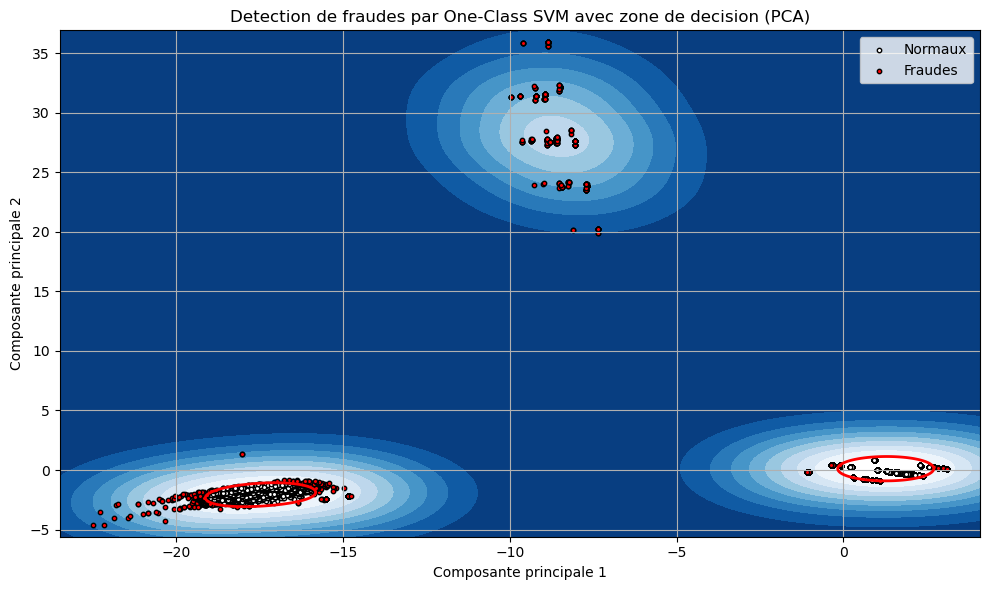

In [28]:
# Etape 3 : visualisation du resultat avec matplotlib
plt.figure(figsize=(10, 6))

# afficher les zones normales en bleues
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 10), cmap=plt.cm.Blues_r)

# Courbe rouge = frontière de décision (Z = 0)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')

# Affichage des points normaux en blanc
plt.scatter(X_pca[y_pred == 1, 0], X_pca[y_pred == 1, 1],
            c='white', edgecolors='k', s=10, label="Normaux")
# Affichage des points anrmaux en rouge
plt.scatter(X_pca[y_pred == -1, 0], X_pca[y_pred == -1, 1],
            c='red', edgecolors='k', s=10, label="Fraudes")

# Mise en forme
plt.title("Detection de fraudes par One-Class SVM avec zone de decision (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Étape 1 : Ajouter les résultats bruts du modèle
features_df['anomalie_svm'] = y_pred  # 1 = normal, -1 = anomalie

# Étape 2 : Créer une colonne binaire plus lisible
features_df['is_fraud_svm'] = features_df['anomalie_svm'].apply(lambda x: 1 if x == -1 else 0)

# (Optionnel) Étape 3 : Ajouter une description textuelle lisible
features_df['fraud_status'] = features_df['is_fraud_svm'].apply(lambda x: "Fraude détectée" if x == 1 else "Normale")

#. Afficher le nombre total de fraudes détectées
nombre_fraudes = features_df['is_fraud_svm'].sum()
print(f"Nombre de fraudes détectées : {nombre_fraudes}")

# Sauvegarde (ajout de is_fraud au dataset)
features_df.to_csv("../features/features_transactions_SVM_avec_fraude.csv", index=False)
print("Fichier enrichi avec is_fraud exporté.")

Nombre de fraudes détectées : 1390
Fichier enrichi avec is_fraud exporté.


In [40]:
#Rapport fraude

# Charger les utilisateurs avec les noms
features_df = pd.read_csv("../features/features_transactions.csv")
user_df = pd.read_csv("../datasets/user.csv")
user_df.rename(columns={'id': 'user_id'}, inplace=True)  # Pour éviter conflit avec id dans df_fraude

# Charger le fichier des fraudes détectées (contenant la colonne is_fraud)
df_fraude = pd.read_csv('../features/features_transactions_SVM_avec_fraude.csv')

# S’assurer que les deux colonnes user_id sont de même type
df_fraude['user_id'] = df_fraude['user_id'].astype(int)
user_df['user_id'] = user_df['user_id'].astype(int)
df_fraude['user_id'] = range(1, len(df_fraude) + 1)

# Fusionner pour ajouter le nom d’utilisateur
df_rapport = pd.merge(df_fraude, user_df[['user_id', 'username']], on='user_id', how='left')

# Regles :

# Charger le fichier nettoyes bill
bill_df = pd.read_csv("../datasets/bill_cleaned.csv")
bill_features = pd.DataFrame()

# Regle B1 :montant seuil par jour
#. Montant total des transactions PAR JOUR PAR UTILISATEUR
if "proceed_at" in bill_df.columns and "amount" in bill_df.columns and "id" in bill_df.columns:
    # Conversion de la date en jour seulement
    bill_df['jour_transaction'] = pd.to_datetime(bill_df['proceed_at']).dt.date

    # Calcul du total des montants par utilisateur et par jour
    montant_par_jour = bill_df.groupby(['id', 'jour_transaction'])['amount'].sum().reset_index()

    # Marquer comme suspect si le total journalier dépasse 1 000 000
    montant_par_jour['montant_eleve_jour'] = (montant_par_jour['amount'] >= 1_000_000).astype(int)

    # Fusionner l'indicateur avec le DataFrame original
    bill_df = bill_df.merge(montant_par_jour[['id', 'jour_transaction', 'montant_eleve_jour']],
                            on=['id', 'jour_transaction'], how='left')

    # Remplir les valeurs manquantes
    bill_df['montant_eleve_jour'] = bill_df['montant_eleve_jour'].fillna(0).astype(int)
  # Ramener l'indicateur dans le tableau des features par utilisateur
    bill_features['b1_montant_suspect'] = bill_df.groupby('id')['montant_eleve_jour'].max()

else:
    print("Attention : proceed_at, amount ou id manquant dans bill_df")


   
# Règle B2 : KYC absent
features_df['b2_kyc_absent'] = features_df.get('kyc_status_NOT_INITIATED', 0).fillna(0).astype(bool).astype(int)

# Règle B3 : montant > solde
features_df['b3_montant_trade_exces'] = features_df.apply(lambda row: 1 if row['amount'] > row.get('trade_balance', 0) else 0, axis=1)

#
colonnes_regles = ['b1_montant_suspect', 'b2_kyc_absent', 'b3_montant_trade_exces']
for col in colonnes_regles:
    if col in features_df.columns:
        df_rapport[col] = features_df[col]

# Description
def generer_description(row):
    raisons = []
    if row.get('b1_montant_suspect', False) or row.get('montant_eleve_jour', 0) == 1:
        raisons.append("Montant élevé détecté sur une journée")
    if row.get('b2_kyc_absent', False):
        raisons.append("KYC non validé")
    if row.get('b3_montant_trade_exces', False):
        raisons.append("Montant superieur au solde")
    return "/ ".join(raisons) if raisons else "comportement suspect détecté par le modèle"
    
# Application
df_rapport['description'] = df_rapport.apply(
    lambda row: generer_description(row) if row['is_fraud_svm'] == 1 else "",
    axis=1
)

# . Sélection des colonnes intéressantes pour le rapport
colonnes_affichage = ['user_id', 'username_y', 'is_fraud_svm', 'description']
rapport_final = df_rapport[df_rapport['is_fraud_svm'] == 1][colonnes_affichage]

# .suppression des lignes avec des valeurs manquantes (NaN)
rapport_final = rapport_final.dropna(subset=['username_y', 'user_id'])

#9. Convertir la colonne 'id' en int
rapport_final['user_id'] = rapport_final['user_id'].astype(int)

# Exporter vers CSV
rapport_final.to_csv("../features/rapport_fraude_transactions_SVM.csv", index=False)

# Affichage d’un aperçu
print("Utilisateurs détectés comme fraudeurs :")
display(rapport_final)

Utilisateurs détectés comme fraudeurs :


,user_id,username_y,is_fraud_svm,description
25,26,AFRIJOB,1,KYC non validé
32,33,immoleas,1,KYC non validé
51,52,Ghislain Pettoun,1,KYC non validé
54,55,Ngang Kellymorra tengue,1,KYC non validé
58,59,DJOUMESSI RUSEL,1,KYC non validé
77,78,KAMENI Marie Ornéla,1,KYC non validé
80,81,Jules César KETCHAKOU,1,KYC non validé
84,85,MagicGode,1,KYC non validé
106,107,Amanwa danra salomon,1,KYC non validé
110,111,Kemte tchanegha lyn VANeLLE,1,KYC non validé


In [31]:
#--------- alogorithme k-means --------

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [32]:
# 2. Appliquer K-Means
features_df = pd.read_csv("../features/features_transactions.csv") 

# filtrage des colonnes numeriques
X = features_df.select_dtypes(include=['int64', 'float64'])

k = 3  # Nombre de clusters
kmeans = KMeans(n_clusters=k, random_state=42)
features_df['cluster'] = kmeans.fit_predict(X)

In [33]:
# 3. Afficher les centroïdes (caractéristiques moyennes par groupe)

print("----- Centroïdes des clusters -----")
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(centroides)

----- Centroïdes des clusters -----
    user_id  username  last_operation   balance      nb_trans   contact  \
0  0.010759  0.001479        0.855712  0.199933  1.393649e-07  0.000379   
1  0.559328  0.000414        0.739577  0.199777  4.986560e-04  0.000380   
2  0.373561  0.000394        0.687314  0.201759  3.405965e-03  0.000395   

   rewards_balance  matricule  last_login  last_host_location  ...  \
0         0.986840   0.000416    0.001767           39.999689  ...   
1         0.000314   0.156747    0.226882           16.362659  ...   
2         0.001132   0.117561    0.293892            9.981061  ...   

   trade_balance  currency_id_2.0  currency_id_3.0  currency_id_4.0  \
0   7.021173e-01     2.033324e-03     2.033324e-03     2.033324e-03   
1   3.308465e-14    -8.218252e-17    -8.218252e-17    -8.218252e-17   
2  -1.776357e-15     1.994932e-17     1.994932e-17     1.994932e-17   

   currency_id_5.0  currency_id_7.0  currency_id_8.0  currency_id_14.0  \
0              0.0     

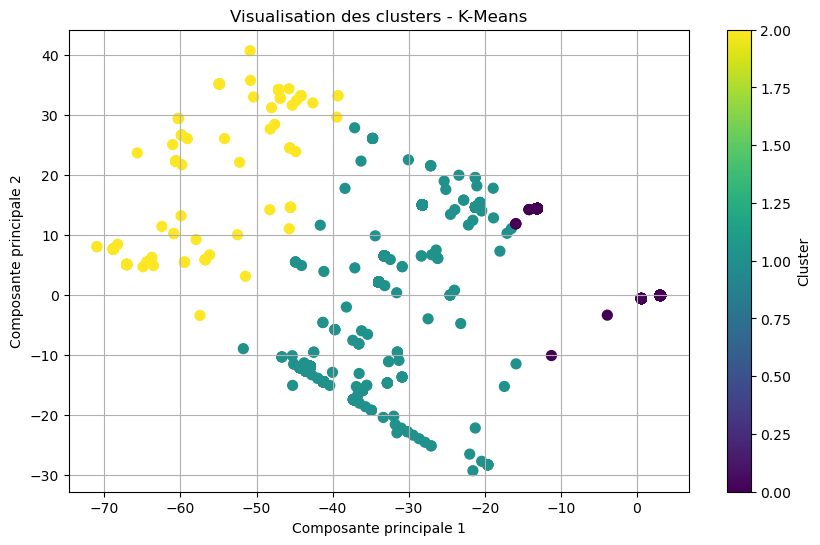

In [34]:
# 4. Visualisation des clusters avec PCA (réduction à 2 dimensions)
pca = PCA(n_components=2)
X_reduit = pca.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(X_reduit[:, 0], X_reduit[:, 1], c=features_df['cluster'], cmap='viridis', s=50)
plt.title("Visualisation des clusters - K-Means")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.show()

In [35]:
# 5. Sauvegarder le DataFrame avec les clusters
features_df.to_csv("../features/features_transactions_avec_clusters.csv", index=False)
print("Fichier exporté : features_transactions_avec_clusters.csv")

Fichier exporté : features_transactions_avec_clusters.csv


In [36]:
#fusion des resultats clustering + detection de fraudes

# 1. Charger les fichiers
clusters_df = pd.read_csv("../features/features_transactions_avec_clusters.csv")  # Contient la colonne 'cluster'
isoforest_df = pd.read_csv("../features/features_transactions_isolation_forest_avec_fraude.csv")  # Contient 'is_fraud'
svm_df = pd.read_csv("../features/features_transactions_SVM_avec_fraude.csv")  # Contient 'is_fraud'

# 2. Renommer les colonnes pour éviter les conflits
isoforest_df = isoforest_df.rename(columns={"is_fraud": "is_fraud_isolation"})
svm_df = svm_df.rename(columns={"is_fraud_svm": "is_fraud_svm"})

# 3. Fusionner les DataFrames sur l’index (chaque ligne = un utilisateur identique)
fusion_temp = pd.merge(clusters_df, isoforest_df[["is_fraud_isolation"]], left_index=True, right_index=True)
fusion_finale = pd.merge(fusion_temp, svm_df[["is_fraud_svm"]], left_index=True, right_index=True)

# 4. Enregistrer le fichier fusionné
fusion_finale.to_csv("../features/features_transactions_clusters_isoforest_svm.csv", index=False)
print("Fichier de fusion créé avec succès : features_transactions_clusters_isoforest_svm.csv")

# 5. Aperçu du résultat
print(fusion_finale.head())

Fichier de fusion créé avec succès : features_transactions_clusters_isoforest_svm.csv
   user_id  username  date_start  last_operation   balance  nb_trans  \
0      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   
1      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   
2      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   
3      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   
4      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   

    contact  rewards_balance  matricule  last_login  ...  currency_id_4.0  \
0  0.000374              1.0   0.000374    0.000374  ...              0.0   
1  0.000374              1.0   0.000374    0.000374  ...              0.0   
2  0.000374              1.0   0.000374    0.000374  ...              0.0   
3  0.000374              1.0   0.000374    0.000374  ...              0.0   
4  0.000374              1.0   0.000374    0.000374  ...              0.0   

   currency_id_5.0

In [37]:
#rapport clusters

# 1. Charger le fichier fusionné
# Ce fichier doit contenir les colonnes : cluster, is_fraud_isolation, is_fraud_svm
df = pd.read_csv("../features/features_transactions_clusters_isoforest_svm.csv")

# 2. Grouper les utilisateurs par cluster et compter
rapport = df.groupby("cluster").agg(
    total_utilisateurs=("cluster", "count"),                  # Total d'utilisateurs dans chaque cluster
    nb_fraudes_isoforest=("is_fraud_isolation", "sum"),       # Total de fraudes détectées par Isolation Forest
    nb_fraudes_svm=("is_fraud_svm", "sum")                    # Total de fraudes détectées par SVM
)

# 3. Calculer les taux de fraude (%) par méthode
rapport["taux_fraude_isoforest (%)"] = (
    rapport["nb_fraudes_isoforest"] / rapport["total_utilisateurs"] * 100
).round(2)

rapport["taux_fraude_svm (%)"] = (
    rapport["nb_fraudes_svm"] / rapport["total_utilisateurs"] * 100
).round(2)

# 4. Afficher le rapport
print("=== Rapport de Fraude par Cluster ===")
print(rapport)

# 5. Sauvegarder le rapport en CSV si besoin
rapport.to_csv("../features/rapport_fraude_par_cluster.csv", index=True)
print("\nRapport exporté : rapport_fraude_transactions_par_cluster.csv")

=== Rapport de Fraude par Cluster ===
         total_utilisateurs  nb_fraudes_isoforest  nb_fraudes_svm  \
cluster                                                             
0                     35410                   608            1067   
1                      2046                   178             183   
2                       528                   354             140   

         taux_fraude_isoforest (%)  taux_fraude_svm (%)  
cluster                                                  
0                             1.72                 3.01  
1                             8.70                 8.94  
2                            67.05                26.52  

Rapport exporté : rapport_fraude_transactions_par_cluster.csv


In [38]:
#  Rapport final

# Étape 1 : Chargement des fichiers CSV
# -------------------------------------
# Chargement des données contenant les informations de clustering
clusters_df = pd.read_csv("../features/features_transactions_avec_clusters.csv")

# Chargement des résultats du modèle Isolation Forest
isoforest_df = pd.read_csv("../features/rapport_fraude_transactions_isoforest.csv")

# Chargement des résultats du modèle SVM
svm_df = pd.read_csv("../features/rapport_fraude_transactions_SVM.csv")

#chargement du fichier brut User

users_df = pd.read_csv("../datasets/user.csv")

# Étape 2 : Harmonisation des colonnes pour la fusion
# ---------------------------------------------------
# Renommage de la colonne 'user_id' en 'id' pour uniformiser les clés de fusion
clusters_df = clusters_df.rename(columns={"user_id": "id"}).astype({"id": int})

# Conversion de id pretraites en id brut
clusters_df['id'] = range(1, len(clusters_df) + 1)

# Renommage des colonnes de résultats pour éviter les conflits lors de la fusion
isoforest_df = isoforest_df.rename(columns={"is_fraud": "is_fraud_isolation"})
svm_df = svm_df.rename(columns={"is_fraud_svm": "is_fraud_svm"})

# Étape 3 : Fusion des données

# Fusion clusters + Isolation Forest
fusion_temp = pd.merge(clusters_df, isoforest_df[['id', 'is_fraud_isolation', 'description']], on='id', how='left')

# Fusion avec SVM
fusion_finale = pd.merge(fusion_temp, svm_df[['id', 'is_fraud_svm']], on='id', how='left')

# Fusion avec noms d'utilisateur
rapport_avec_noms = pd.merge(fusion_finale, users_df[['id', 'username']], on='id', how='left')
# === ÉTAPE 6 : Réorganiser les colonnes dans l'ordre souhaité ===
colonnes_ordre = ['id', 'username', 'cluster', 'is_fraud_isolation', 'is_fraud_svm', 'description']
rapport_avec_noms = rapport_avec_noms[colonnes_ordre]

# Étape 7 : Supprimer les lignes avec des valeurs manquantes
rapport_propre = rapport_avec_noms.dropna()

# Afficher un aperçu du rapport nettoyé
print("Aperçu du rapport sans valeurs manquantes :")
display(rapport_propre.head())
display(rapport_avec_noms)
# Étape 8 : Exporter le rapport propre
chemin_non_propre = "../features/rapport_fraude_transaction_clusters_avec_noms.csv"
chemin_propre = "../features/rapport_fraude_transactions_clusters_avec_noms_sans_nan.csv"
rapport_propre.to_csv(chemin_propre, index=False)
rapport_avpropre.to_csv(chemin_propre, index=False)
print(f"\nRapport propre exporté avec succès : {chemin_propre}")
print(f"\nRapport propre exporté avec succès : {chemin_non_propre}")

KeyError: "['id', 'is_fraud_isolation'] not in index"